In [3]:
import sys
sys.path.append('../')
from attacks import get_advdist, get_detector
from loader import get_dataloader

import numpy as np
import matplotlib.pyplot as plt
import torch
import os
from omegaconf import OmegaConf

In [35]:
train_dl = get_dataloader({'dataset': 'RImgNet', 
                           'split':'training', 
                           'path': '../datasets', 
                           'batch_size': 64, 
                           'n_workers': 8, 
                           'shuffle':False})

Using No Augmentations
Using No Augmentations


In [50]:
train_dl = get_dataloader({'dataset': 'CIFAR10_OOD', 
                           'split':'training_full', 
                           'path': '../datasets', 
                           'batch_size': 64, 
                           'n_workers': 8, 
                           'shuffle':False})

Using No Augmentations
Using No Augmentations
Files already downloaded and verified
Files already downloaded and verified


In [16]:
model = get_detector(**OmegaConf.load('../configs/cifar_detectors/cifar_vit_hf_md.yml'), root='../')

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using vit_eval aug with params {'size': 224}


In [67]:
from datasets import load_dataset
cifar10_train_ds = load_dataset('cifar10', split='train')

Found cached dataset cifar10 (/root/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4)


In [7]:
path = '../results/CIFAR10/pairwise/vit_hf_md/vit_hf_md/svhn_pgstylegan2_z16_mh/'
samples = torch.load(os.path.join(path, 'sample.pkl'))
ranks = torch.load(os.path.join(path, 'rank.pkl'))

In [19]:
agom_sample = samples[np.argsort(ranks)[0:5]]

In [79]:
agom_rank = np.sort(ranks)[0:5]

In [27]:
v = model.model.forward_prelogit(model.transform(agom_sample))

In [86]:
((prelogit - v[[0]]) ** 2).sum(dim=1).min().item()

1.584071159362793

In [95]:
((prelogit - v[[0]]) ** 2).sum(dim=1).mean().item()

81.1277084350586

In [101]:
model.model.all_means.shape

torch.Size([1, 768, 10])

In [104]:
((model.model.all_means[0].permute(1,0) - v[[0]]) ** 2).sum(dim=1).sqrt()

tensor([1.1177, 9.4185, 9.1973, 9.4456, 9.3517, 9.2454, 9.3175, 9.3694, 9.2715,
        9.3959], dtype=torch.float64, grad_fn=<SqrtBackward0>)

In [25]:
prelogit = torch.load('../pretrained/cifar_ood_vit/hf/prelogit.pkl')

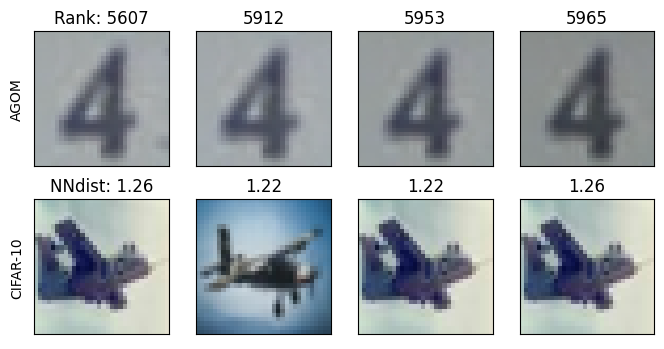

In [94]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(8,4))

axs[0,0].imshow(agom_sample[0].permute(1,2,0))
axs[0,0].set_title(f'Rank: {agom_rank[0]}')
axs[0,0].set_ylabel('AGOM')
axs[0,1].imshow(agom_sample[1].permute(1,2,0))
axs[0,1].set_title(agom_rank[1])
axs[0,2].imshow(agom_sample[2].permute(1,2,0))
axs[0,2].set_title(agom_rank[2])
axs[0,3].imshow(agom_sample[3].permute(1,2,0))
axs[0,3].set_title(agom_rank[3])

axs[1,0].imshow(cifar10_train_ds[26637]['img'])
axs[1,0].set_ylabel('CIFAR-10')
axs[1,0].set_title(f'NNdist: {((prelogit - v[[0]]) ** 2).sum(dim=1).sqrt().min().item():.2f}')
axs[1,1].imshow(cifar10_train_ds[15712]['img'])
axs[1,1].set_title(f'{((prelogit - v[[1]]) ** 2).sum(dim=1).sqrt().min().item():.2f}')
axs[1,2].imshow(cifar10_train_ds[26637]['img'])
axs[1,2].set_title(f'{((prelogit - v[[2]]) ** 2).sum(dim=1).sqrt().min().item():.2f}')
axs[1,3].imshow(cifar10_train_ds[26637]['img'])
axs[1,3].set_title(f'{((prelogit - v[[3]]) ** 2).sum(dim=1).sqrt().min().item():.2f}')
for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
plt.savefig('nearest_analysis.pdf', dpi=300)

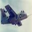

In [72]:
cifar10_train_ds[26637]['img']

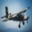

In [73]:
cifar10_train_ds[15712]['img']

In [26]:
prelogit.shape

torch.Size([50000, 768])

In [28]:
v.shape

torch.Size([5, 768])

In [56]:
((prelogit - v[[0]]) ** 2).sum(dim=1)#.min()

tensor([ 2.8576, 88.9841,  2.7583,  ..., 93.6668, 89.6880, 89.1909],
       grad_fn=<SumBackward1>)

In [53]:
((prelogit - v[[0]]) ** 2).sum(dim=1).argmin()

tensor(26637)

In [57]:
((prelogit - v[[1]]) ** 2).sum(dim=1).argmin()

tensor(15712)

In [58]:
((prelogit - v[[2]]) ** 2).sum(dim=1).argmin()

tensor(26637)

In [59]:
((prelogit - v[[3]]) ** 2).sum(dim=1).argmin()

tensor(26637)

In [54]:
img, _ = train_dl.dataset[26637]

In [60]:
in_v = model.model.forward_prelogit(model.transform(img.unsqueeze(0)))

In [63]:
prelogit[26637][:5]

tensor([ 0.2299,  0.1929,  0.1114, -0.0656,  0.1710])

In [66]:
in_v[0,:5]

tensor([-0.1944,  0.0791,  0.2393, -0.2510, -0.2956], grad_fn=<SliceBackward0>)

In [27]:
v = model.model.forward_prelogit(model.transform(agom_sample))

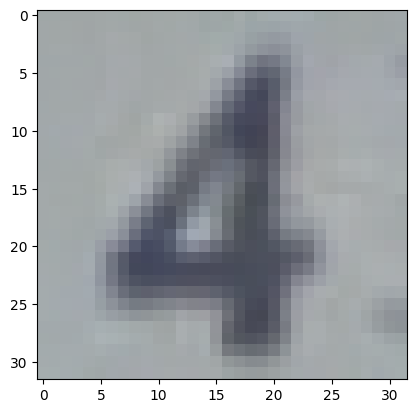

In [11]:
plt.imshow(samples[np.argsort(ranks)[0]].permute(1,2,0))